# Taller RAG - Comparativo modelos con SOLR y Milvus
Docente: **Luis Gabriel Moreno Sandoval**

---
*Grupo Número 1:*

- LUCENA ORJUELA, JULIAN
- MARTINEZ BERMUDEZ, JUAN
- MONTENEGRO MAFLA, MARIA
- REYES PALACIO, FELIPE 

## 1. Carga de librerías y configuraciones generales

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

# Configuración de estilo para los gráficos
sns.set_theme(style="whitegrid")
%matplotlib inline

ARCHIVO_RESULTADOS = "evaluation_results.csv"
ARCHIVO_ERRORES = 'errores_consulta.csv'


## 2. Cargar los Resultados
Cargamos el archivo CSV que generó nuestro script de evaluación.

In [2]:
# Cargar en un DataFrame
try:
    df = pd.read_csv(ARCHIVO_RESULTADOS)
    print(f"¡Datos de evaluación {ARCHIVO_RESULTADOS} cargados exitosamente!")
    print(f"Total de registros: {len(df)}")
    df.head()
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en {file_path}")
    print("Asegúrate de que el notebook esté en la carpeta correcta.")

¡Datos de evaluación evaluation_results.csv cargados exitosamente!
Total de registros: 216


## 2.5. Validacion de errores

Este nuevo proceso suprime los casos de errores causados por la generación de la respuesta, de forma tal que no afecten las métricas posteriores.

Se imprimen los casos de error para futuras correcciones.

In [3]:
# --- CELDA 2.5: Filtrar Errores de Generación del LLM ---

print("--- 2.5. Filtrando errores de generación del LLM ---")

# Define el prefijo de error exacto que vimos en los logs
error_prefix = "Error al generar la respuesta:"

# 1. Crear una máscara booleana para encontrar los errores
#    'na=False' asegura que si hay algún NaN, no se marque como error
error_mask = df['generated_answer'].str.startswith(error_prefix, na=False)

# 2. Separar el DataFrame en dos: uno para errores y otro para éxitos
df_errors = df[error_mask]
df_success = df[~error_mask]

# 3. Informar al usuario y mostrar los errores eliminados
print(f"Se encontraron {len(df_errors)} registros con error (de un total de {len(df)}).")

if len(df_errors) > 0:
    print("\n--- Errores de Generación Eliminados del Análisis ---")
    # Imprimimos las columnas clave de los errores para que puedas revisarlos
    print(df_errors[['query', 'backend', 'generated_answer']].to_markdown(index=False))
    df_errors.to_csv(ARCHIVO_ERRORES,encoding='utf-8',sep=',')
    print(f"Guardados los errores de consultas en: {ARCHIVO_ERRORES}")

# 4. Sobrescribir el DataFrame principal
#    Ahora, 'df' solo contiene las filas donde la generación fue exitosa.
df = df_success

print(f"\n--- Análisis continuará con {len(df)} registros exitosos. ---")



--- 2.5. Filtrando errores de generación del LLM ---
Se encontraron 0 registros con error (de un total de 216).

--- Análisis continuará con 216 registros exitosos. ---


## 3. Calcular Métricas Promedio
Aquí calculamos la tabla de resumen. Agrupamos por backend y calculamos la media de cada métrica.

In [4]:
# Definir las métricas que queremos analizar
# (Cambiamos 'latency_sec' por 'total_latency_sec' y añadimos 'retrieval_latency_sec')
metric_columns = ['total_latency_sec', 
                  'retrieval_latency_sec', 
                  'recall_at_k', 
                  'mrr_at_k', 
                  'rouge_l_f1']

# Agrupar por 'backend' y calcular la media
df_summary = df.groupby('backend')[metric_columns].mean()

print("--- Resumen de Métricas (Promedio) ---")
# Esta celda ya no fallará, ya que 'tabulate' está instalado
print(df_summary.to_markdown(floatfmt=".4f"))

--- Resumen de Métricas (Promedio) ---
| backend   |   total_latency_sec |   retrieval_latency_sec |   recall_at_k |   mrr_at_k |   rouge_l_f1 |
|:----------|--------------------:|------------------------:|--------------:|-----------:|-------------:|
| milvus    |              3.9674 |                  0.0027 |        0.1636 |     0.2452 |       0.1717 |
| solr      |              3.9219 |                 -0.0059 |        0.1503 |     0.1989 |       0.1572 |


---
**¿Cómo Interpretar esta Tabla?**

Esta tabla resume todo el análisis. Así es como se lee cada métrica:

* **`total_latency_sec` (Latencia Total):**
    * **Qué mide:** El tiempo promedio total (en segundos) que experimenta el usuario, desde que envía la pregunta hasta que la API de Gemini genera la respuesta.
    * **Mejor es:** **Más bajo**.

* **`retrieval_latency_sec` (Latencia de Recuperación):**
    * **Qué mide:** El tiempo promedio (en segundos) que le tomó *únicamente* al backend (Solr o Milvus) encontrar los documentos. Esta es la **comparación de velocidad real** del buscador.
    * **Mejor es:** **Más bajo**.

* **`recall_at_k` (Recall@k):**
    * **Qué mide:** De todas las respuestas "correctas" (tus `relevant_chunk_ids`), ¿qué porcentaje fue *encontrado* por el buscador?
    * **Mejor es:** **Más alto**. Mide la "exhaustividad" (qué tan bueno es para *encontrar*).

* **`mrr_at_k` (Mean Reciprocal Rank):**
    * **Qué mide:** Qué tan alto en la lista (del 1 al `k`) apareció el *primer* documento correcto.
    * **Mejor es:** **Más alto**. Mide la "precisión en la cima" (qué tan bueno es para *clasificar*).

* **`rouge_l_f1` (ROUGE-L):**
    * **Qué mide:** La similitud entre la `generated_answer` (ahora de Gemini) y tu `ideal_answer`.
    * **Mejor es:** **Más alto**. Mide la "calidad de generación" final.

## 4. Visualización de latencia

Ya que tenemos dos métricas de latencia, les daremos su propio gráfico de 1x2 (1 fila, 2 columnas) para un análisis claro.

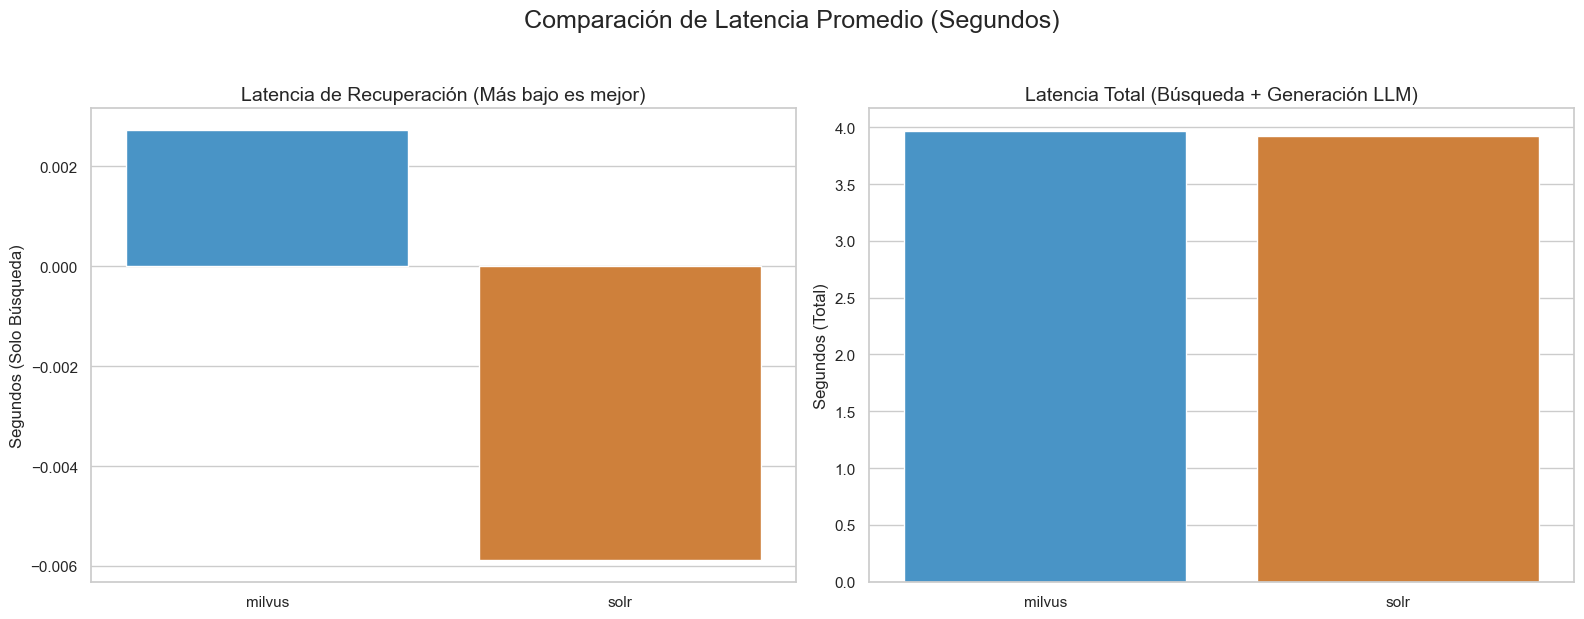

In [5]:
# --- Gráfico 1: Comparación de Latencias ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Comparación de Latencia Promedio (Segundos)', fontsize=18, y=1.03)

palette = {"solr": "#E67E22", "milvus": "#3498DB"}
hue_order = df_summary.index

# 1. Latencia de Recuperación (Backend vs. Backend)
sns.barplot(data=df_summary, x=df_summary.index, y='retrieval_latency_sec', ax=axes[0], palette=palette, 
            hue=hue_order, legend=False)
axes[0].set_title('Latencia de Recuperación (Más bajo es mejor)', fontsize=14)
axes[0].set_ylabel('Segundos (Solo Búsqueda)')
axes[0].set_xlabel('')

# 2. Latencia Total (Experiencia de Usuario)
sns.barplot(data=df_summary, x=df_summary.index, y='total_latency_sec', ax=axes[1], palette=palette, 
            hue=hue_order, legend=False)
axes[1].set_title('Latencia Total (Búsqueda + Generación LLM)', fontsize=14)
axes[1].set_ylabel('Segundos (Total)')
axes[1].set_xlabel('')

plt.tight_layout()
plt.savefig('comparativa_latencia.png')
plt.show()

## 5. Visualización Comparativa (Promedios)
Una tabla es buena, pero los gráficos son mejores. Se crea un gráfico de barras para cada una de las 4 métricas, comparando Solr y Milvus.

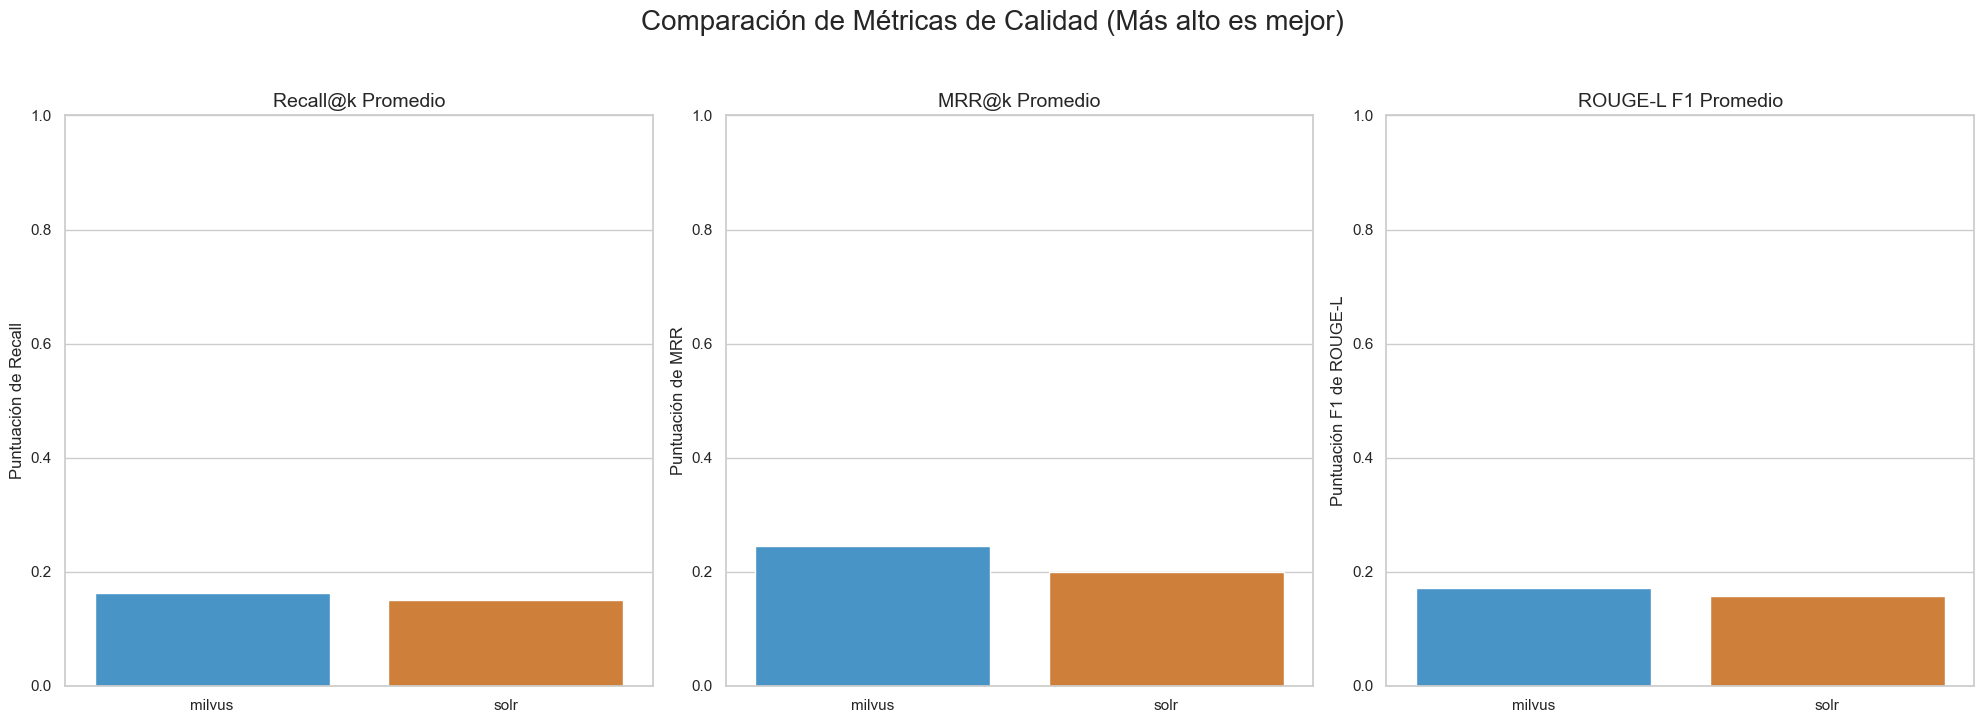

In [6]:
# --- Gráfico 2: Comparación de Métricas de Calidad ---
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('Comparación de Métricas de Calidad (Más alto es mejor)', fontsize=20, y=1.03)

palette = {"solr": "#E67E22", "milvus": "#3498DB"}
hue_order = df_summary.index

# 1. Recall@k
sns.barplot(data=df_summary, x=df_summary.index, y='recall_at_k', ax=axes[0], palette=palette, 
            hue=hue_order, legend=False)
axes[0].set_title('Recall@k Promedio', fontsize=14)
axes[0].set_ylabel('Puntuación de Recall')
axes[0].set_xlabel('')
axes[0].set_ylim(0, 1) # Recall es de 0 a 1

# 2. MRR@k
sns.barplot(data=df_summary, x=df_summary.index, y='mrr_at_k', ax=axes[1], palette=palette, 
            hue=hue_order, legend=False)
axes[1].set_title('MRR@k Promedio', fontsize=14)
axes[1].set_ylabel('Puntuación de MRR')
axes[1].set_xlabel('')
axes[1].set_ylim(0, 1) # MRR es de 0 a 1

# 3. ROUGE-L
sns.barplot(data=df_summary, x=df_summary.index, y='rouge_l_f1', ax=axes[2], palette=palette, 
            hue=hue_order, legend=False)
axes[2].set_title('ROUGE-L F1 Promedio', fontsize=14)
axes[2].set_ylabel('Puntuación F1 de ROUGE-L')
axes[2].set_xlabel('')
axes[2].set_ylim(0, 1) # ROUGE es de 0 a 1

# Ajustar el layout y guardar la imagen
plt.tight_layout()
plt.show()

## 6. Análisis de Distribución
Los promedios pueden ser engañosos. ¿Es un backend consistentemente bueno, o solo tuvo suerte en algunas preguntas? Un boxplot (diagrama de caja) nos muestra la distribución de los resultados.

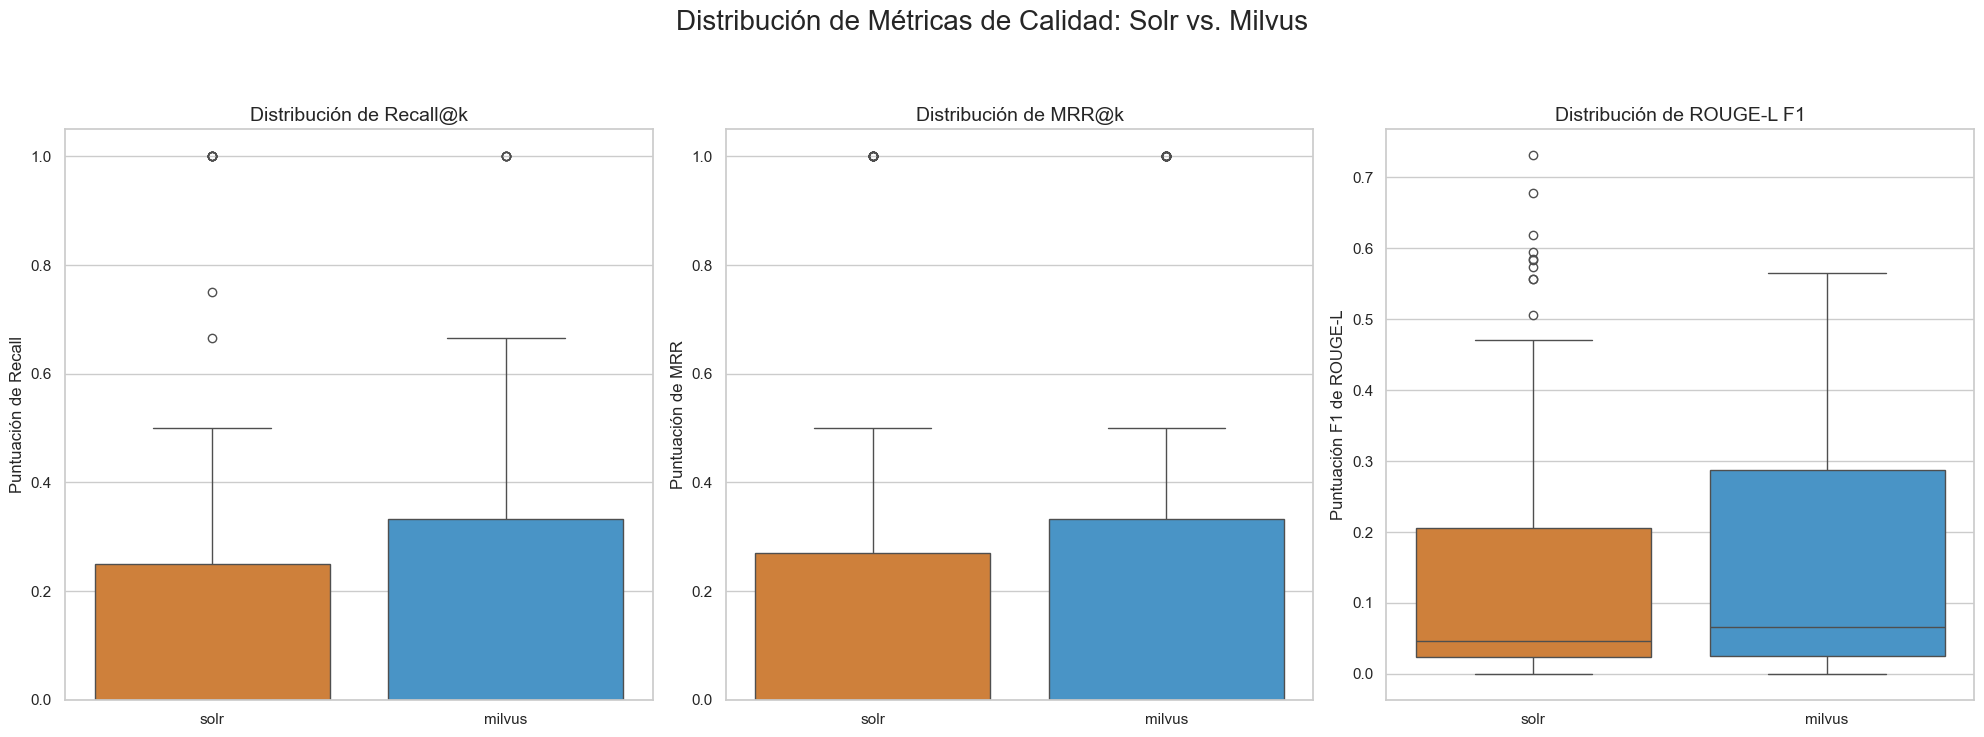

In [7]:
# --- Gráfico 3: Distribución de Métricas de Calidad ---
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('Distribución de Métricas de Calidad: Solr vs. Milvus', fontsize=20, y=1.05)

palette = {"solr": "#E67E22", "milvus": "#3498DB"}
hue_order = ['solr', 'milvus'] # Para asegurar el orden

# 1. Distribución de Recall@k
sns.boxplot(data=df, x='backend', y='recall_at_k', ax=axes[0], palette=palette, 
            hue='backend', legend=False, order=hue_order)
axes[0].set_title('Distribución de Recall@k', fontsize=14)
axes[0].set_ylabel('Puntuación de Recall')
axes[0].set_xlabel('')
axes[0].set_ylim(0, 1.05)

# 2. Distribución de MRR@k
sns.boxplot(data=df, x='backend', y='mrr_at_k', ax=axes[1], palette=palette, 
            hue='backend', legend=False, order=hue_order)
axes[1].set_title('Distribución de MRR@k', fontsize=14)
axes[1].set_ylabel('Puntuación de MRR')
axes[1].set_xlabel('')
axes[1].set_ylim(0, 1.05)

# 3. Distribución de ROUGE-L
sns.boxplot(data=df, x='backend', y='rouge_l_f1', ax=axes[2], palette=palette, 
            hue='backend', legend=False, order=hue_order)
axes[2].set_title('Distribución de ROUGE-L F1', fontsize=14)
axes[2].set_ylabel('Puntuación F1 de ROUGE-L')
axes[2].set_xlabel('')

# Guardar y mostrar
plt.tight_layout()
plt.show()